# Visualización del Impacto de Indicadores de Desarrollo y Energías Renovables

Este notebook explora cómo afectan los diferentes indicadores de desarrollo de un país en el cambio climático y analiza cómo ayudaría el uso de energías renovables en la mitigación del cambio climático.

## Configuración del Entorno

Importamos las bibliotecas necesarias y establecemos la conexión con la base de datos.

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymysql
from dotenv import load_dotenv
from matplotlib.ticker import FuncFormatter
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Configuración visual
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Cargar variables de entorno y conectar a la base de datos
load_dotenv()
conn = pymysql.connect(
    host=os.getenv('DB_HOST'),
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD'),
    database=os.getenv('DB_NAME')
)

# Funciones de formato para ejes
def formato_millones(x, pos):
    return f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}k'

def formato_miles_millones(x, pos):
    return f'{x/1e9:.1f}B' if x >= 1e9 else f'{x/1e6:.1f}M'

## 1. Resumen de Datos de Desarrollo Disponibles

Exploramos la cantidad de datos disponibles para diferentes indicadores de desarrollo.

C:\Users\david\AppData\Local\Temp\ipykernel_8476\2570225248.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_resumen = pd.read_sql(query_resumen, conn)


Resumen de indicadores de desarrollo disponibles:
                     codigo  \
0              temperaturas   
1               emision_co2   
2               SP.POP.TOTL   
3            AG.LND.TOTL.K2   
4            NY.GDP.MKTP.CD   
5      EN.GHG.CO2.RT.GDP.KD   
6   EN.GHG.CO2.RT.GDP.PP.KD   
7            EG.ELC.RNWX.KH   
8            EG.ELC.FOSL.ZS   
9            EG.ELC.RNWX.ZS   
10           EG.ELC.RNEW.ZS   

                                          descripcion   categoria  num_paises  \
0                                   Temperatura media   Ambiental         229   
1                                      Emisión de CO₂   Ambiental         198   
2      Población total (estimaciones de mitad de año)  Demografía         213   
3   Superficie terrestre total (excluye aguas inte...  Demografía         213   
4                        Producto Interno Bruto (PIB)    Economía         209   
5   Intensidad de carbono del PIB (US$ constantes ...    Economía         197   
6         

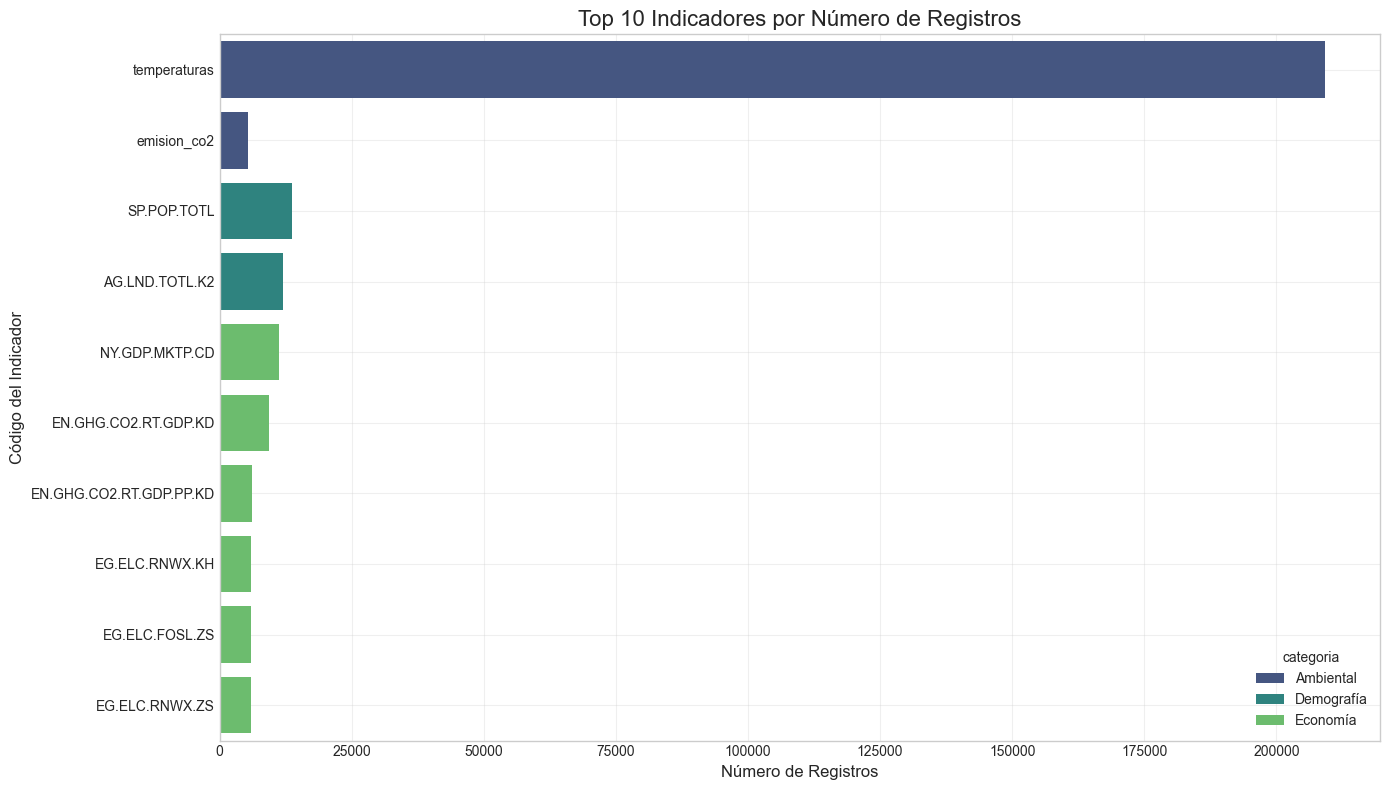

In [3]:
# Consulta para obtener resumen de indicadores de desarrollo
query_resumen = """
SELECT 
    i.codigo,
    i.descripcion,
    c.nombre AS categoria,
    COUNT(DISTINCT p.codigo) AS num_paises,
    MIN(h.anio) AS anio_min,
    MAX(h.anio) AS anio_max,
    COUNT(*) AS num_registros
FROM Hechos h
JOIN Paises p ON h.pais_id = p.codigo
JOIN Indicadores i ON h.indicador_id = i.id
JOIN Categorias c ON i.categoria_id = c.id
WHERE c.nombre IN ('Economía', 'Demografía', 'Ambiental')
GROUP BY i.codigo, i.descripcion, c.nombre
ORDER BY c.nombre, num_registros DESC;
"""

df_resumen = pd.read_sql(query_resumen, conn)

# Mostrar resumen
print("Resumen de indicadores de desarrollo disponibles:")
print(df_resumen[['codigo', 'descripcion', 'categoria', 'num_paises', 'num_registros']])

# Crear gráfico de barras para número de registros por indicador
plt.figure(figsize=(14, 8))
df_top_indicadores = df_resumen.head(10)
sns.barplot(data=df_top_indicadores, y='codigo', x='num_registros', hue='categoria', palette='viridis')

plt.xlabel('Número de Registros')
plt.ylabel('Código del Indicador')
plt.title('Top 10 Indicadores por Número de Registros', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Análisis de Indicadores de Desarrollo vs Emisiones

Analizamos la relación entre diferentes indicadores de desarrollo y las emisiones de CO₂.

In [4]:
# Consulta para obtener múltiples indicadores de desarrollo y emisiones
query_desarrollo = """
SELECT 
    p.nombre_en AS pais,
    p.codigo AS codigo_pais,
    c.nombre AS continente,
    MAX(CASE WHEN i.codigo = 'emision_co2' THEN h.valor ELSE NULL END) AS emisiones_co2,
    MAX(CASE WHEN i.codigo = 'NY.GDP.MKTP.CD' THEN h.valor ELSE NULL END) AS pib,
    MAX(CASE WHEN i.codigo = 'SP.POP.TOTL' THEN h.valor ELSE NULL END) AS poblacion,
    MAX(CASE WHEN i.codigo = 'AG.LND.TOTL.K2' THEN h.valor ELSE NULL END) AS superficie,
    MAX(CASE WHEN i.codigo = 'EG.ELC.FOSL.ZS' THEN h.valor ELSE NULL END) AS energia_fosil,
    MAX(CASE WHEN i.codigo = 'EG.ELC.RNEW.ZS' THEN h.valor ELSE NULL END) AS energia_renovable,
    MAX(CASE WHEN i.codigo = 'EG.ELC.RNWX.ZS' THEN h.valor ELSE NULL END) AS energia_renovable_no_hidro
FROM Hechos h
JOIN Paises p ON h.pais_id = p.codigo
JOIN Subcontinentes s ON p.subcontinente_id = s.id
JOIN Continentes c ON s.continente_id = c.id
JOIN Indicadores i ON h.indicador_id = i.id
WHERE i.codigo IN ('emision_co2', 'NY.GDP.MKTP.CD', 'SP.POP.TOTL', 'AG.LND.TOTL.K2', 
                   'EG.ELC.FOSL.ZS', 'EG.ELC.RNEW.ZS', 'EG.ELC.RNWX.ZS')
AND h.anio >= 2015
GROUP BY p.nombre_en, p.codigo, c.nombre
HAVING emisiones_co2 IS NOT NULL AND pib IS NOT NULL AND poblacion IS NOT NULL;
"""

df_desarrollo = pd.read_sql(query_desarrollo, conn)

# Calcular indicadores derivados
df_desarrollo['emisiones_per_capita'] = df_desarrollo['emisiones_co2'] * 1000000 / df_desarrollo['poblacion']
df_desarrollo['pib_per_capita'] = df_desarrollo['pib'] / df_desarrollo['poblacion']
df_desarrollo['densidad_poblacion'] = df_desarrollo['poblacion'] / df_desarrollo['superficie']
df_desarrollo['intensidad_carbono'] = df_desarrollo['emisiones_co2'] * 1000000 / df_desarrollo['pib']

print(f"Datos de desarrollo para {len(df_desarrollo)} países")
print("\nEstadísticas descriptivas:")
print(df_desarrollo[['emisiones_per_capita', 'pib_per_capita', 'energia_renovable', 'energia_fosil']].describe())

Datos de desarrollo para 184 países

Estadísticas descriptivas:
       emisiones_per_capita  pib_per_capita  energia_renovable  energia_fosil
count            184.000000      184.000000         184.000000     131.000000
mean              27.757946    19876.498350          32.165515      59.064379
std              240.351404    26116.603575          31.775707      32.615505
min                0.031856      243.890209           0.000000       0.000000
25%                0.949635     2665.842759           3.569721      35.294260
50%                3.580928     8162.703775          20.726478      62.806506
75%                7.344698    25729.197576          53.530310      91.172957
max             3255.866173   128678.189943         100.000000     100.000000


C:\Users\david\AppData\Local\Temp\ipykernel_8476\1225328875.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_desarrollo = pd.read_sql(query_desarrollo, conn)


## 3. Relación entre PIB per Cápita y Emisiones per Cápita

Analizamos la curva de Kuznets ambiental para las emisiones de CO₂.

C:\Users\david\AppData\Local\Temp\ipykernel_8476\4030062559.py:55: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
d:\AA-MAster\TFM-Cambio-Climatico\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


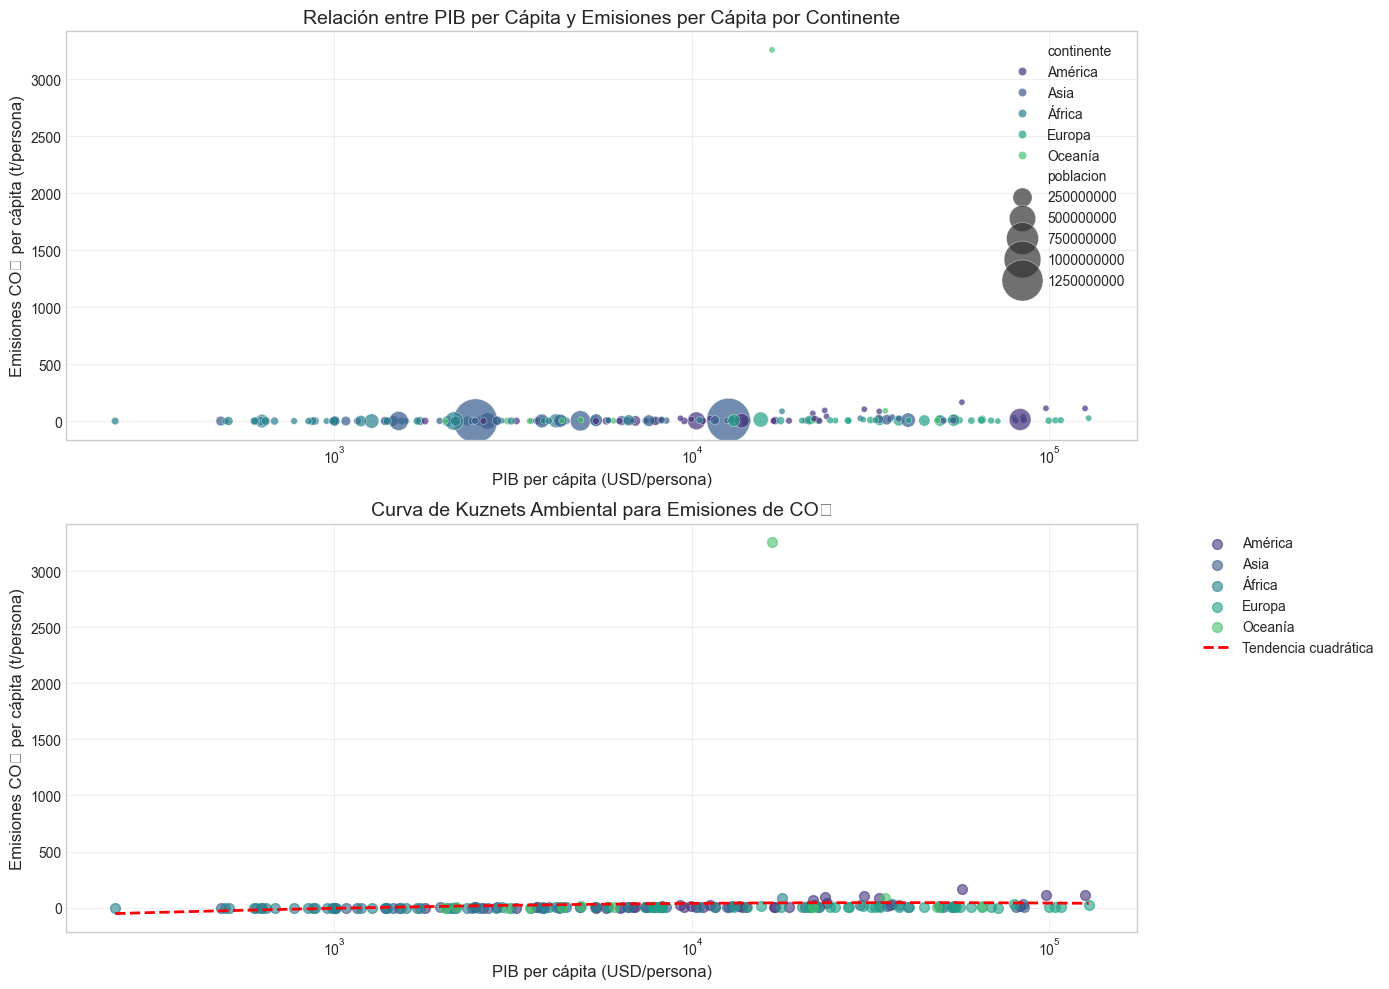

In [5]:
# Crear gráfico de dispersión PIB per cápita vs Emisiones per cápita
plt.figure(figsize=(14, 10))

# Gráfico principal
plt.subplot(2, 1, 1)
sns.scatterplot(
    data=df_desarrollo,
    x='pib_per_capita',
    y='emisiones_per_capita',
    hue='continente',
    size='poblacion',
    sizes=(20, 1000),
    alpha=0.7
)

# Añadir etiquetas para países destacados
paises_destacados = ['USA', 'CHN', 'IND', 'DEU', 'JPN', 'RUS', 'BRA', 'GBR', 'FRA', 'ESP']
for idx, row in df_desarrollo[df_desarrollo['codigo_pais'].isin(paises_destacados)].iterrows():
    plt.annotate(row['codigo_pais'], 
                xy=(row['pib_per_capita'], row['emisiones_per_capita']), 
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=9,
                fontweight='bold')

plt.xscale('log')
plt.xlabel('PIB per cápita (USD/persona)')
plt.ylabel('Emisiones CO₂ per cápita (t/persona)')
plt.title('Relación entre PIB per Cápita y Emisiones per Cápita por Continente', fontsize=14)
plt.grid(True, alpha=0.3)

# Gráfico de densidad por continente
plt.subplot(2, 1, 2)
for continente in df_desarrollo['continente'].unique():
    df_cont = df_desarrollo[df_desarrollo['continente'] == continente]
    plt.scatter(df_cont['pib_per_capita'], df_cont['emisiones_per_capita'], 
               label=continente, alpha=0.6, s=50)

# Añadir línea de tendencia global
x = np.log10(df_desarrollo['pib_per_capita'])
y = df_desarrollo['emisiones_per_capita']
mask = ~np.isnan(x) & ~np.isnan(y)
z = np.polyfit(x[mask], y[mask], 2)  # Ajuste cuadrático
p = np.poly1d(z)
x_smooth = np.linspace(x[mask].min(), x[mask].max(), 100)
plt.plot(10**x_smooth, p(x_smooth), 'r--', linewidth=2, label='Tendencia cuadrática')

plt.xscale('log')
plt.xlabel('PIB per cápita (USD/persona)')
plt.ylabel('Emisiones CO₂ per cápita (t/persona)')
plt.title('Curva de Kuznets Ambiental para Emisiones de CO₂', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## 4. Análisis del Impacto de las Energías Renovables

Exploramos cómo el uso de energías renovables afecta las emisiones de CO₂.

C:\Users\david\AppData\Local\Temp\ipykernel_8476\650381592.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_energia['categoria_renovable'] = pd.cut(
C:\Users\david\AppData\Local\Temp\ipykernel_8476\650381592.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_energia, x='categoria_renovable', y='emisiones_per_capita', palette='viridis')
C:\Users\david\AppData\Local\Temp\ipykernel_8476\650381592.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  

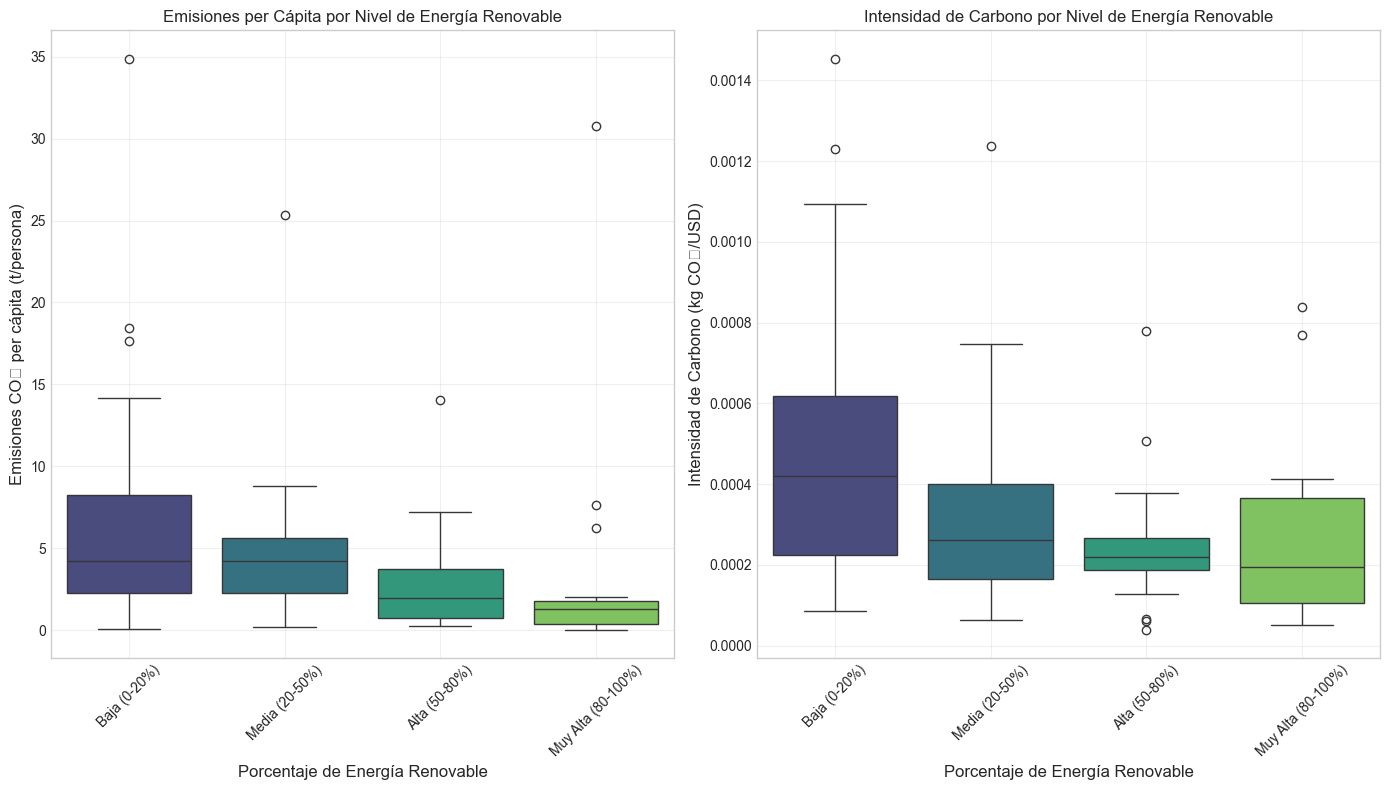

Correlaciones entre energía y emisiones:
Energía renovable vs Emisiones per cápita: -0.295
Energía renovable vs Intensidad de carbono: -0.381
Energía fósil vs Emisiones per cápita: 0.239


In [6]:
# Filtrar países con datos de energía renovable
df_energia = df_desarrollo.dropna(subset=['energia_renovable', 'energia_fosil'])

# Crear categorías de países según su uso de energías renovables
df_energia['categoria_renovable'] = pd.cut(
    df_energia['energia_renovable'], 
    bins=[0, 20, 50, 80, 100], 
    labels=['Baja (0-20%)', 'Media (20-50%)', 'Alta (50-80%)', 'Muy Alta (80-100%)']
)

# Crear gráfico de caja para emisiones por categoría de energía renovable
plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_energia, x='categoria_renovable', y='emisiones_per_capita', palette='viridis')
plt.xlabel('Porcentaje de Energía Renovable')
plt.ylabel('Emisiones CO₂ per cápita (t/persona)')
plt.title('Emisiones per Cápita por Nivel de Energía Renovable', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
sns.boxplot(data=df_energia, x='categoria_renovable', y='intensidad_carbono', palette='viridis')
plt.xlabel('Porcentaje de Energía Renovable')
plt.ylabel('Intensidad de Carbono (kg CO₂/USD)')
plt.title('Intensidad de Carbono por Nivel de Energía Renovable', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calcular correlaciones
corr_renovable_emisiones = df_energia['energia_renovable'].corr(df_energia['emisiones_per_capita'])
corr_renovable_intensidad = df_energia['energia_renovable'].corr(df_energia['intensidad_carbono'])
corr_fosil_emisiones = df_energia['energia_fosil'].corr(df_energia['emisiones_per_capita'])

print("Correlaciones entre energía y emisiones:")
print(f"Energía renovable vs Emisiones per cápita: {corr_renovable_emisiones:.3f}")
print(f"Energía renovable vs Intensidad de carbono: {corr_renovable_intensidad:.3f}")
print(f"Energía fósil vs Emisiones per cápita: {corr_fosil_emisiones:.3f}")

## 5. Análisis de Países Líderes en Energías Renovables

Identificamos y analizamos los países que lideran en el uso de energías renovables.

C:\Users\david\AppData\Local\Temp\ipykernel_8476\3039550801.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_lideres_renovables, y='pais', x='energia_renovable', palette='viridis')
C:\Users\david\AppData\Local\Temp\ipykernel_8476\3039550801.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_lideres_renovables, y='pais', x='diferencia_promedio', palette=colores)
C:\Users\david\AppData\Local\Temp\ipykernel_8476\3039550801.py:31: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
d:\AA-MAster\TFM-Cambio-Climatico\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s)

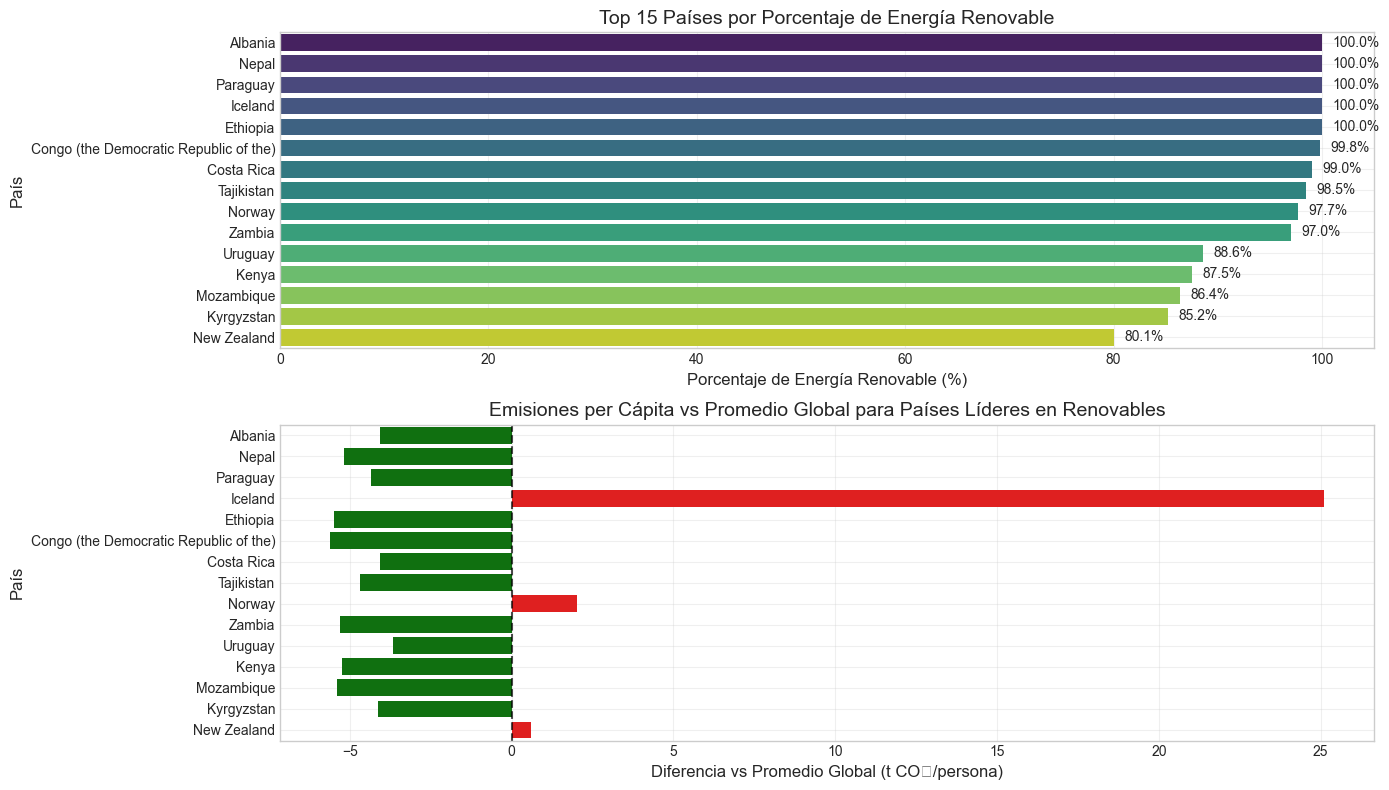

Promedio global de emisiones per cápita: 5.65 t CO₂/persona
Promedio de países líderes en renovables: 3.69 t CO₂/persona


In [7]:
# Identificar países líderes en energías renovables
df_lideres_renovables = df_energia.nlargest(15, 'energia_renovable')

# Crear gráfico de barras para países líderes
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
sns.barplot(data=df_lideres_renovables, y='pais', x='energia_renovable', palette='viridis')
plt.xlabel('Porcentaje de Energía Renovable (%)')
plt.ylabel('País')
plt.title('Top 15 Países por Porcentaje de Energía Renovable', fontsize=14)
plt.grid(True, alpha=0.3)

# Añadir etiquetas con valores
for i, v in enumerate(df_lideres_renovables['energia_renovable']):
    plt.text(v + 1, i, f'{v:.1f}%', va='center')

plt.subplot(2, 1, 2)
# Comparar emisiones per cápita de países líderes vs promedio global
promedio_global = df_energia['emisiones_per_capita'].mean()
df_lideres_renovables['diferencia_promedio'] = df_lideres_renovables['emisiones_per_capita'] - promedio_global

colores = ['green' if x < 0 else 'red' for x in df_lideres_renovables['diferencia_promedio']]
sns.barplot(data=df_lideres_renovables, y='pais', x='diferencia_promedio', palette=colores)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7)
plt.xlabel('Diferencia vs Promedio Global (t CO₂/persona)')
plt.ylabel('País')
plt.title('Emisiones per Cápita vs Promedio Global para Países Líderes en Renovables', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Promedio global de emisiones per cápita: {promedio_global:.2f} t CO₂/persona")
print(f"Promedio de países líderes en renovables: {df_lideres_renovables['emisiones_per_capita'].mean():.2f} t CO₂/persona")

## 6. Evolución Temporal de Energías Renovables

Analizamos cómo ha evolucionado el uso de energías renovables a lo largo del tiempo.

C:\Users\david\AppData\Local\Temp\ipykernel_8476\1574548194.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_evolucion = pd.read_sql(query_evolucion_renovables, conn)


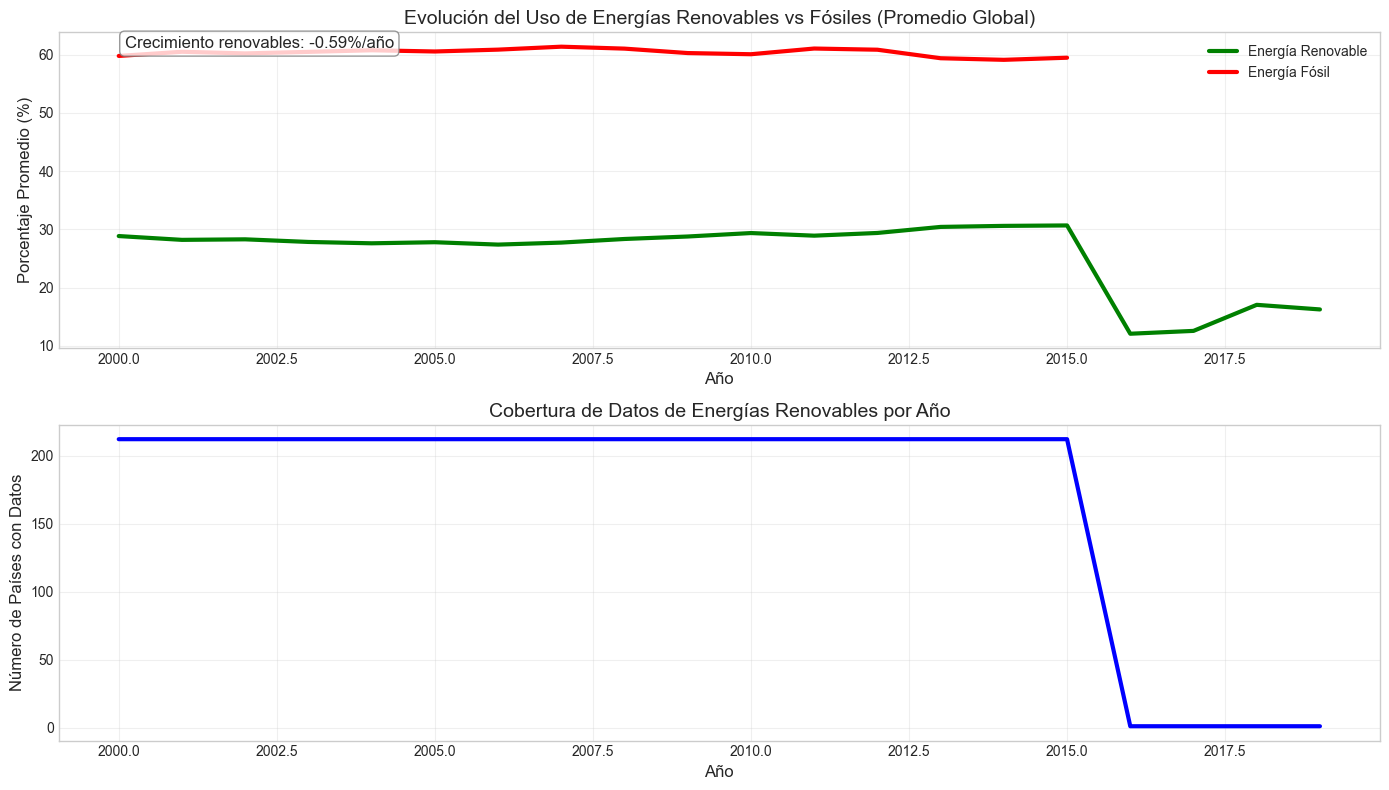

In [8]:
# Consulta para obtener evolución temporal de energías renovables
query_evolucion_renovables = """
SELECT 
    h.anio,
    AVG(CASE WHEN i.codigo = 'EG.ELC.RNEW.ZS' THEN h.valor ELSE NULL END) AS energia_renovable_promedio,
    AVG(CASE WHEN i.codigo = 'EG.ELC.FOSL.ZS' THEN h.valor ELSE NULL END) AS energia_fosil_promedio,
    COUNT(DISTINCT CASE WHEN i.codigo = 'EG.ELC.RNEW.ZS' THEN p.codigo ELSE NULL END) AS num_paises_renovable
FROM Hechos h
JOIN Paises p ON h.pais_id = p.codigo
JOIN Indicadores i ON h.indicador_id = i.id
WHERE i.codigo IN ('EG.ELC.RNEW.ZS', 'EG.ELC.FOSL.ZS')
AND h.anio >= 2000
GROUP BY h.anio
ORDER BY h.anio;
"""

df_evolucion = pd.read_sql(query_evolucion_renovables, conn)

# Crear gráfico de evolución temporal
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
sns.lineplot(data=df_evolucion, x='anio', y='energia_renovable_promedio', linewidth=3, color='green', label='Energía Renovable')
sns.lineplot(data=df_evolucion, x='anio', y='energia_fosil_promedio', linewidth=3, color='red', label='Energía Fósil')

plt.xlabel('Año')
plt.ylabel('Porcentaje Promedio (%)')
plt.title('Evolución del Uso de Energías Renovables vs Fósiles (Promedio Global)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

# Calcular tasa de crecimiento de energías renovables
x = df_evolucion['anio']
y = df_evolucion['energia_renovable_promedio']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.annotate(f'Crecimiento renovables: {slope:.2f}%/año', 
            xy=(0.05, 0.95), 
            xycoords='axes fraction',
            fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.subplot(2, 1, 2)
sns.lineplot(data=df_evolucion, x='anio', y='num_paises_renovable', linewidth=3, color='blue')
plt.xlabel('Año')
plt.ylabel('Número de Países con Datos')
plt.title('Cobertura de Datos de Energías Renovables por Año', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Análisis de Correlación Multivariable

Examinamos las correlaciones entre todos los indicadores de desarrollo y ambientales.

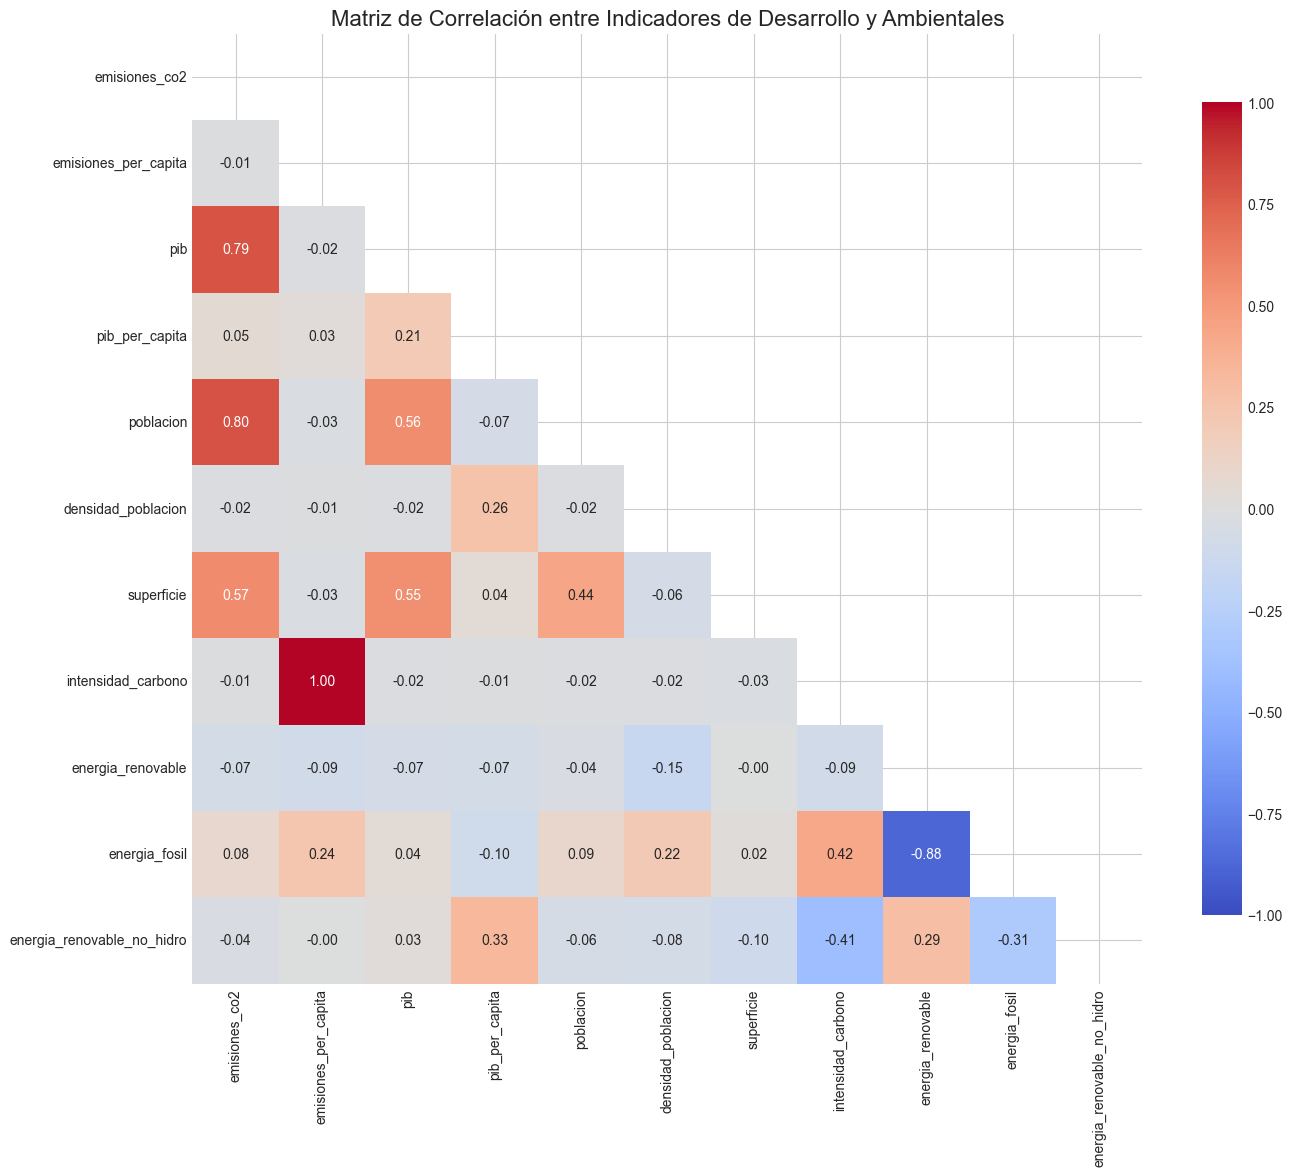

Correlaciones más fuertes con emisiones per cápita:
intensidad_carbono: +0.998
energia_fosil: +0.239
energia_renovable: -0.092
superficie: -0.030
pib_per_capita: +0.029
poblacion: -0.027
pib: -0.018
densidad_poblacion: -0.014
emisiones_co2: -0.011


In [9]:
# Seleccionar variables para análisis de correlación
variables_correlacion = [
    'emisiones_co2', 'emisiones_per_capita', 'pib', 'pib_per_capita', 
    'poblacion', 'densidad_poblacion', 'superficie', 'intensidad_carbono',
    'energia_renovable', 'energia_fosil', 'energia_renovable_no_hidro'
]

# Calcular matriz de correlación
df_corr = df_desarrollo[variables_correlacion].corr()

# Crear mapa de calor de correlaciones
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(df_corr, dtype=bool))  # Máscara para mostrar solo la mitad inferior
sns.heatmap(df_corr, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            center=0, fmt='.2f', square=True, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación entre Indicadores de Desarrollo y Ambientales', fontsize=16)
plt.tight_layout()
plt.show()

# Identificar correlaciones más fuertes con emisiones
correlaciones_emisiones = df_corr['emisiones_per_capita'].abs().sort_values(ascending=False)
print("Correlaciones más fuertes con emisiones per cápita:")
for var, corr in correlaciones_emisiones.head(10).items():
    if var != 'emisiones_per_capita':
        signo = '+' if df_corr.loc['emisiones_per_capita', var] > 0 else '-'
        print(f"{var}: {signo}{corr:.3f}")

## 8. Conclusiones

A partir del análisis realizado, podemos extraer las siguientes conclusiones sobre el impacto de los indicadores de desarrollo y las energías renovables:

1. **Relación PIB-Emisiones**: Existe una correlación positiva entre el PIB per cápita y las emisiones per cápita, pero esta relación no es lineal. Los países más desarrollados tienden a tener emisiones más altas, aunque algunos muestran signos de desacoplamiento.

2. **Impacto de las energías renovables**: Los países con mayor porcentaje de energías renovables tienden a tener menores emisiones per cápita e intensidad de carbono, demostrando el potencial de estas tecnologías para la descarbonización.

3. **Líderes en renovables**: Los países líderes en energías renovables no necesariamente son los más desarrollados económicamente, lo que sugiere que la transición energética es posible en diferentes niveles de desarrollo.

4. **Evolución temporal**: El uso de energías renovables ha mostrado una tendencia creciente a nivel global, aunque aún insuficiente para alcanzar los objetivos climáticos.

5. **Factores múltiples**: Las emisiones de CO₂ están influenciadas por múltiples factores de desarrollo (PIB, población, densidad, mix energético), lo que requiere enfoques integrales para su reducción.

6. **Oportunidades de mitigación**: La transición hacia energías renovables representa una de las estrategias más efectivas para reducir emisiones, con beneficios tanto ambientales como de desarrollo sostenible.

Estos hallazgos subrayan la importancia de acelerar la transición energética hacia fuentes renovables como estrategia clave para la mitigación del cambio climático, especialmente en países en desarrollo que aún pueden moldear su trayectoria energética.

In [10]:
# Cerrar conexión a la base de datos
conn.close()